In [1]:
import findspark

####TODO:  replace the original one
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
# findspark.init(r"C:\ProgramData\spark\spark-2.1.1-bin-hadoop2.7")
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4_b').getOrCreate()

In [2]:
df = spark.read.format("csv").options(header="true", inferschema = "true").option("quote", "\"").option("escape", "\"").load("cleaned.csv")

In [3]:
df.printSchema()

root
 |-- self-employed: integer (nullable = true)
 |-- company_size: string (nullable = true)
 |-- IT_industry: integer (nullable = true)
 |-- mental_health_coverage: string (nullable = true)
 |-- awareness_opt_for_mh_under_coverage: string (nullable = true)
 |-- employer_formally_discussed_mh: string (nullable = true)
 |-- employer_provide_mh_resources_and_support: string (nullable = true)
 |-- comfortable_discuss_mh_with_coworker: string (nullable = true)
 |-- comfortable_discuss_mh_with_supervisor: string (nullable = true)
 |-- has_prev_employers: integer (nullable = true)
 |-- prev_employers_provided_mh_benefits: string (nullable = true)
 |-- awareness_opt_for_mh_under_coverage_provided_by_prev_employers: string (nullable = true)
 |-- prev_employers_formally_discuss_mh: string (nullable = true)
 |-- prev_employers_provide_mh_resources_and_support: string (nullable = true)
 |-- willingness_to discuss_mh_with_prev_co-workers: string (nullable = true)
 |-- willingness_to_discuss_mh_w

In [4]:
# 4 transformation

# 4.2 data projection

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

continues_col = "age"
target = "mh_disorder_current"


string_col = [c for c in df.columns if (c not in continues_col) & (c not in target)]

# use string indexer to encode each col in 
indexers = [StringIndexer(inputCol=col, outputCol="IDX_" + col) for col in string_col]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="VEC_{0}".format(indexer.getOutputCol())) for indexer in indexers]


input_cols =[encoder.getOutputCol() for encoder in encoders]
input_cols.append("age")

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
df_encoded  = pipeline.fit(df).transform(df)

In [5]:
# encoding label
target = "mh_disorder_current"
targetIndexer = StringIndexer(inputCol=target, outputCol="IDX_mh_disorder_current")
indexer_model= targetIndexer.fit(df_encoded)
df_encoded = indexer_model.transform(df_encoded)

df_encoded.printSchema()

root
 |-- self-employed: integer (nullable = true)
 |-- company_size: string (nullable = true)
 |-- IT_industry: integer (nullable = true)
 |-- mental_health_coverage: string (nullable = true)
 |-- awareness_opt_for_mh_under_coverage: string (nullable = true)
 |-- employer_formally_discussed_mh: string (nullable = true)
 |-- employer_provide_mh_resources_and_support: string (nullable = true)
 |-- comfortable_discuss_mh_with_coworker: string (nullable = true)
 |-- comfortable_discuss_mh_with_supervisor: string (nullable = true)
 |-- has_prev_employers: integer (nullable = true)
 |-- prev_employers_provided_mh_benefits: string (nullable = true)
 |-- awareness_opt_for_mh_under_coverage_provided_by_prev_employers: string (nullable = true)
 |-- prev_employers_formally_discuss_mh: string (nullable = true)
 |-- prev_employers_provide_mh_resources_and_support: string (nullable = true)
 |-- willingness_to discuss_mh_with_prev_co-workers: string (nullable = true)
 |-- willingness_to_discuss_mh_w

In [6]:
label_col = "IDX_mh_disorder_current"

from pyspark.ml.feature import ChiSqSelector
selector = ChiSqSelector(numTopFeatures=7, featuresCol="features",
                         outputCol="selectedFeatures", labelCol=label_col)

df_selected = selector.fit(df_encoded).transform(df_encoded)

model = selector.fit(df_encoded)

selectedFeatures_index = model.selectedFeatures
# selectedFeatures_index

selectedFeatures = [df_encoded.columns[i] for i in selectedFeatures_index]
# selectedFeatures

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
df_selected.select("selectedFeatures").show(truncate = False)

ChiSqSelector output with top 7 features selected
+-------------------------------+
|selectedFeatures               |
+-------------------------------+
|(7,[0,3,4,6],[1.0,1.0,1.0,1.0])|
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[3],[1.0])                  |
|(7,[0,3,4,6],[1.0,1.0,1.0,1.0])|
|(7,[1,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[1,3,5],[1.0,1.0,1.0])      |
|(7,[0,3,5],[1.0,1.0,1.0])      |
|(7,[2,4,6],[1.0,1.0,1.0])      |
|(7,[2,4,6],[1.0,1.0,1.0])      |
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[4,6],[1.0,1.0])            |
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[1,3],[1.0,1.0])            |
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[1,2,4,6],[1.0,1.0,1.0,1.0])|
|(7,[3,5],[1.0,1.0])            |
|(7,[4,6],[1.0,1.0])            |
|(7,[0,2,4,6],[1.0,1.0,1.0,1.0])|
+-------------------------------+
only showing top 20 rows



In [7]:
df_trim = df_selected.select("selectedFeatures", label_col)
df_trim = df_trim.withColumnRenamed(label_col, "label")

In [8]:
# 6. algorithm selection
#6.2 
train_data, test_data = df_trim.randomSplit([0.7,0.3], seed = 10)


from pyspark.ml.classification import LogisticRegression,GBTClassifier,RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier

rfc = RandomForestClassifier(labelCol="label",featuresCol="selectedFeatures")
lr = LogisticRegression(labelCol="label", featuresCol="selectedFeatures",)
nb = NaiveBayes(labelCol="label", featuresCol="selectedFeatures")

rfc_model = rfc.fit(train_data)
lr_model = lr.fit(train_data)
nb_model = nb.fit(train_data)

rfc_predictions = rfc_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)
nb_predictions = nb_model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label")
# Random Forest
print("Random Forest Classification accuracy: ", "{:.3f}".format(evaluator.evaluate(rfc_predictions)))
# Logistic Regression
print("Logistic Regression accuracy: ","{:.3f}".format(evaluator.evaluate(lr_predictions)))
# Naive Bayes
print("Naive Bayes accuracy: ", "{:.3f}".format(evaluator.evaluate(nb_predictions)))

Random Forest Classification accuracy:  0.735
Logistic Regression accuracy:  0.740
Naive Bayes accuracy:  0.585


In [9]:
# 6.3 parameter tunning 

# Random forest cross validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
maxDepth = [3, 5]
impurity =["gini", "entropy"]
numberTrees =  [20, 100, 300]

rfc_paramGrid = ParamGridBuilder() \
    .addGrid(rfc.maxDepth, maxDepth)\
    .addGrid(rfc.impurity, ["gini", "entropy"]) \
    .addGrid(rfc.numTrees, [20, 100, 300]) \
    .build()


rfc_crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=rfc_paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

rfc_best = rfc_crossval.fit(train_data)
rfc_pred = rfc_best.transform(test_data)

In [10]:
# Logistic Regression cross validation
elasticNetParam= [0, 0.5, 0.7 ,1]
regParam = [0.1, 0.05, 0.1 ]

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, elasticNetParam)\
    .addGrid(lr.regParam, regParam) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

lr_best = lr_crossval.fit(train_data)
lr_pred = lr_best.transform(test_data)

In [11]:
import numpy as np
print("Best Random Forest accuracy: {:.3f}".format(evaluator.evaluate(rfc_pred)))
print(rfc_best.getEstimatorParamMaps()[np.argmax(rfc_best.avgMetrics)])

print("Best Logistic Regression accuracy: {:.3f}".format(evaluator.evaluate(lr_pred)))
print(lr_best.getEstimatorParamMaps()[np.argmax(lr_best.avgMetrics) ])

# rfc_best.avgMetrics

Best Random Forest accuracy: 0.735
{Param(parent='RandomForestClassifier_4313a31e3f6bfa7d690a', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini', Param(parent='RandomForestClassifier_4313a31e3f6bfa7d690a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3, Param(parent='RandomForestClassifier_4313a31e3f6bfa7d690a', name='numTrees', doc='Number of trees to train (>= 1).'): 300}
Best Logistic Regression accuracy: 0.737
{Param(parent='LogisticRegression_47079a1de7bf2170b147', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0, Param(parent='LogisticRegression_47079a1de7bf2170b147', name='regParam', doc='regularization parameter (>= 0).'): 0.1}


In [12]:
rfc_best_c = RandomForestClassifier(labelCol="label",\
                                    featuresCol="selectedFeatures",\
                                    maxDepth = 3,\
                                    numTrees = 300, \
                                    impurity="gini")

lr_best_c = LogisticRegression(labelCol="label",\
                               featuresCol="selectedFeatures",\
                               elasticNetParam = 0.5,\
                               regParam = 0.05)

In [13]:
# test 70/30 split
train_data_1, test_data_1 = df_trim.randomSplit([0.7,0.3], seed=10)
rfc_best_model_1 = rfc_best_c.fit(train_data_1)
rfc_pred_train_1 = rfc_best_model_1.transform(train_data_1)
rfc_pred_1 = rfc_best_model_1.transform(test_data_1)
print("Random Forest accuracy on trainning set at 70/30 split: {:.3f}".format(evaluator.evaluate(rfc_pred_train_1)))
print("Random Forest accuracy on testing set at 70/30 split: {:.3f}".format(evaluator.evaluate(rfc_pred_1)))

lr_best_model_1 =lr_best_c.fit(train_data_1)
lr_pred_train_1 = lr_best_model_1.transform(train_data_1)
lr_pred_1 = lr_best_model_1.transform(test_data_1)
print("Logistic Regression accuracy on trainning set at 70/30 split: {:.3f}".format(evaluator.evaluate(lr_pred_train_1)))
print("Logistic Regression accuracy on testing set at 70/30 split: {:.3f}".format(evaluator.evaluate(lr_pred_1)))

Random Forest accuracy on trainning set at 70/30 split: 0.710
Random Forest accuracy on testing set at 70/30 split: 0.735
Logistic Regression accuracy on trainning set at 70/30 split: 0.710
Logistic Regression accuracy on testing set at 70/30 split: 0.732


In [14]:
# test 80/20 split
train_data_2, test_data_2= df_trim.randomSplit([0.8,0.2], seed=10)
rfc_best_model_2 = rfc_best_c.fit(train_data_2)
rfc_pred_train_2 = rfc_best_model_2.transform(train_data_2)
rfc_pred_2 = rfc_best_model_2.transform(test_data_2)
print("Random Forest accuracy on trainning set at 80/20 split: {:.3f}".format(evaluator.evaluate(rfc_pred_train_2)))
print("Random Forest accuracy on testing 0/20 split: {:.3f}".format(evaluator.evaluate(rfc_pred_2)))

lr_best_model_2 =lr_best_c.fit(train_data_2)
lr_pred_train_2 = lr_best_model_2.transform(train_data_2)
lr_pred_2 = lr_best_model_2.transform(test_data_2)
print("Logistic Regression accuracy on trainning set at 80/20 split: {:.3f}".format(evaluator.evaluate(lr_pred_train_2)))
print("Logistic Regression accuracy on testing  80/20 split: {:.3f}".format(evaluator.evaluate(lr_pred_2)))

Random Forest accuracy on trainning set at 80/20 split: 0.714
Random Forest accuracy on testing 0/20 split: 0.734
Logistic Regression accuracy on trainning set at 80/20 split: 0.710
Logistic Regression accuracy on testing  80/20 split: 0.725


In [15]:
# test 90/10 split
train_data_3, test_data_3 = df_trim.randomSplit([0.9,0.1], seed=10)
rfc_best_model_3 = rfc_best_c.fit(train_data_3)
rfc_pred_train_3 = rfc_best_model_3.transform(train_data_3)
rfc_pred_3 = rfc_best_model_3.transform(test_data_3)
print("Random Forest accuracy on trainning set at 90/10 split: {:.3f}".format(evaluator.evaluate(rfc_pred_train_3)))
print("Random Forest accuracy on testing set at 90/10 split: {:.3f}".format(evaluator.evaluate(rfc_pred_3)))

lr_best_model_3 =lr_best_c.fit(train_data_3)
lr_pred_train_3 = lr_best_model_3.transform(train_data_3)
lr_pred_3 = lr_best_model_3.transform(test_data_3)
print("Logistic Regression accuracy on trainning set at 90/10 split: {:.3f}".format(evaluator.evaluate(lr_pred_train_3)))
print("Logistic Regression accuracy on testing set at 90/10 split: {:.3f}".format(evaluator.evaluate(lr_pred_3)))

Random Forest accuracy on trainning set at 90/10 split: 0.712
Random Forest accuracy on testing set at 90/10 split: 0.768
Logistic Regression accuracy on trainning set at 90/10 split: 0.707
Logistic Regression accuracy on testing set at 90/10 split: 0.765


In [16]:
# using a 80/20 split
train_data, test_data = df_trim.randomSplit([0.8,0.2], seed=10)
train_data.cache()
rfc_best_model = rfc_best_c.fit(train_data)
lr_best_model = lr_best_c.fit(train_data)

In [17]:
rfc_pred = rfc_best_model.transform(test_data)
print("Random Forest accuracy: {:.3f}".format(evaluator.evaluate(rfc_pred)))
lr_pred = lr_best_model.transform(test_data)
print("Logistic Regression accuracy: {:.3f}".format(evaluator.evaluate(lr_pred)))

rfc_pred.select("selectedFeatures","label", "prediction").show()
lr_pred.select("selectedFeatures","label", "prediction").show()



rfc_importances = rfc_best_model.featureImportances



# lr_importances = lr_best_model.featureImportances

Random Forest accuracy: 0.734
Logistic Regression accuracy: 0.725
+-------------------+-----+----------+
|   selectedFeatures|label|prediction|
+-------------------+-----+----------+
|          (7,[],[])|  1.0|       2.0|
|          (7,[],[])|  2.0|       2.0|
|          (7,[],[])|  2.0|       2.0|
|          (7,[],[])|  2.0|       2.0|
|          (7,[],[])|  2.0|       2.0|
|          (7,[],[])|  2.0|       2.0|
|      (7,[0],[1.0])|  1.0|       2.0|
|      (7,[0],[1.0])|  1.0|       2.0|
|      (7,[0],[1.0])|  1.0|       2.0|
|      (7,[0],[1.0])|  2.0|       2.0|
|      (7,[0],[1.0])|  2.0|       2.0|
|      (7,[0],[1.0])|  2.0|       2.0|
|      (7,[0],[1.0])|  2.0|       2.0|
|      (7,[0],[1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
|(7,[0,2],[1.0,1.0])|  2.0|       2.0|
+-------------------+-----+----------

In [18]:
import matplotlib.pyplot as plt

feature_list = [f.replace("IDX_", "") for f in selectedFeatures]

x_values = list(range(len(rfc_importances)))

plt.bar(x_values, rfc_importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=45)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances for Ramdom Forest')
plt.show()
# feature_importances = np.array(rf_model.stages[-1].featureImportances)
# userAgentVec = feature_importances[len(feature_names) :].sum()
# feature_importances = feature_importances[:len(feature_names)] + [userAgentVec]
# feature_importance = pd.DataFrame(feature_importances, 
#  index = feature_names,
#  columns = [‘Importance’]).sort_values(by = ‘Importance’, ascending = False)
# feature_importance.plot(kind = ‘bar’, figsize = (20, 7), title = ‘Feature Importance of Random Forest model’)
# plt.xticks(rotation = 60)

<Figure size 640x480 with 1 Axes>

In [19]:
from pyspark.sql.types import FloatType
rfc_preds_and_label = rfc_pred.select("label", "prediction").withColumn("label", rfc_pred["label"].cast(FloatType())).withColumn("prediction", rfc_pred["prediction"].cast(FloatType())).orderBy("prediction").rdd
# predictionAndLabels = test_data.map(lambda lp: (float(model.predict(lp.selecteFeatures)), lp.label))

# rfc_preds_and_label = rfc_pred.select("label", "prediction").rdd
lr_preds_and_label = lr_pred.select("label", "prediction").rdd

In [20]:
from pyspark.mllib.evaluation import MulticlassMetrics

# confusion matrix
rfc_metrics = MulticlassMetrics(rfc_preds_and_label)
print("------Random Forest Confusion matrix------ \n", rfc_metrics.confusionMatrix(),"\n\n\n")
lr_metrics = MulticlassMetrics(lr_preds_and_label)
print("------Logistic Regression Confusion matrix------ \n", lr_metrics.confusionMatrix(), "\n\n\n")

------Random Forest Confusion matrix------ 
 DenseMatrix([[149.,  24.,  33.],
             [  6., 102.,  21.],
             [ 11.,  13.,  59.]]) 



------Logistic Regression Confusion matrix------ 
 DenseMatrix([[149.,  22.,  32.],
             [  6., 107.,  29.],
             [ 11.,  10.,  52.]]) 





In [21]:
# precision
rfc_precision = rfc_metrics.precision()
lr_precision = lr_metrics.precision()
print("Random Forest precision: {:.3f}".format(rfc_precision))
print("Logistic Regression precision: {:.3f}".format(lr_precision))

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:237: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


Random Forest precision: 0.742
Logistic Regression precision: 0.737


In [22]:
# f1 score
rfc_f1Score = rfc_metrics.fMeasure()
lr_f1Score = lr_metrics.fMeasure()
print("Random Forest F1 score: {:.3f}".format(rfc_f1Score))
print("Logistic Regression F1 score: {:.3f}".format(lr_f1Score))

Random Forest F1 score: 0.742
Logistic Regression F1 score: 0.737


/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:262: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


In [23]:
# recall
rfc_recall = rfc_metrics.recall()
lr_recall = lr_metrics.recall()
print("Random Forest recall: {:.3f}".format(rfc_recall))
print("Logistic Regression recall: {:.3f}".format(lr_recall))

Random Forest recall: 0.742
Logistic Regression recall: 0.737


/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:249: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


In [24]:
# evaluator_rmse = MulticlassClassificationEvaluator(metricName="rmse", labelCol="label",
#                                 predictionCol="prediction")

# rfc_mse = evaluator.evaluate(rfc_pred)
# rfc_mse
# # RegressionEvaluator

In [25]:
col1 = "comfortable_discuss_mh_with_coworker"
col2 = "comfortable_discuss_mh_with_supervisor"

data_pd = df.toPandas()

df_1 = (data_pd.groupby([col1,col2]).size()).to_frame("count").reset_index()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Possibly feel comfortable with both", 
          "Not comfortable with supervisor but possible with co-worker",
          "Comfortable with supervisor and possible with co-worker",
         "Not comfortable with co-worker but possible with supervisor",
         "Not comfortable with both",
         "Comfortable with supervisor but not with co-worker",
         "Comfortable with  co-worker and possible with supervisor",
         "Comfortable with co-worker but not with supervisor",
         "Comfortable with both"]
sizes = df_1["count"]
explode = (0, 0, 0, 0, 0.1, 0, 0, 0, 0)  

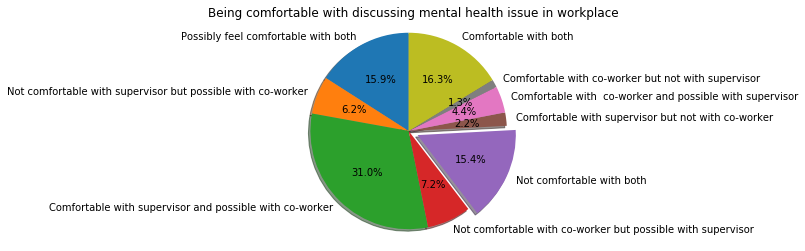

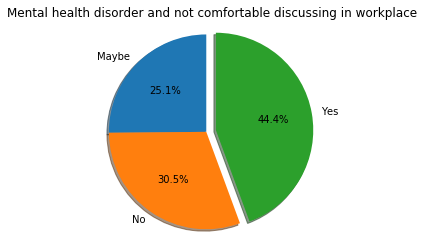

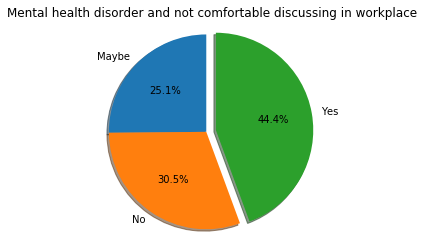

In [26]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Being comfortable with discussing mental health issue in workplace")
plt.show()

col3 = "mh_disorder_current"
# comfort
df2 = (data_pd.groupby([col1,col2,col3]).size()/len(data_pd.index)).to_frame("count").reset_index()
df2 = df2.loc[(df2[col1]=="No") & (df2[col2]=="No")]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Maybe", "No", "Yes"]
size = (df2["count"]/(df2["count"].sum()))
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig2, ax2 = plt.subplots()
ax2.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Mental health disorder and not comfortable discussing in workplace")
plt.show()

df3 = data_pd.copy()
df3["work_remote"] = df3["country_work"].equals(df3["country_live"])

# not comfortable
labels = ["Maybe", "No", "Yes"]
size = (df2["count"]/(df2["count"].sum()))
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig2, ax2 = plt.subplots()
ax2.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Mental health disorder and not comfortable discussing in workplace")
plt.show()

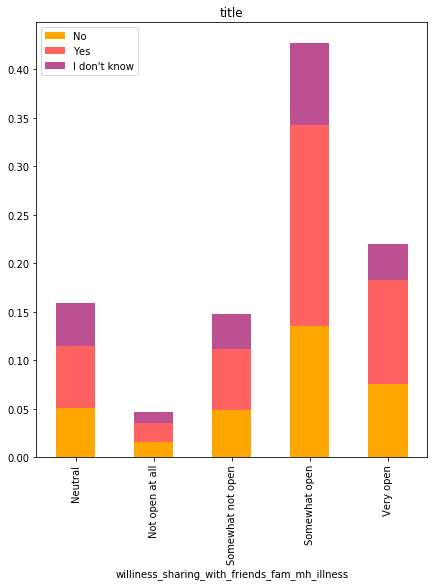

In [27]:
col1 = "williness_sharing_with_friends_fam_mh_illness"
col2 = "family_history"
df_3 = (data_pd.groupby([col1,col2]).size()/len(data_pd.index)).to_frame("count").reset_index()
fig, ax = plt.subplots(figsize=(7,8))  
stacks = data_pd[col2].unique()
margin_bottom = np.zeros(len(df_3[col1].unique()))
colors = ["#ffa600", "#ff6361","#bc5090","#58508d", "#003f5c"]
for num, answer in enumerate(stacks):
    count = list(df_3[df_3[col2] == answer].loc[:, 'count'])

    df_3[df_3[col2] == answer].plot.bar(x=col1,y='count', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=answer)

    margin_bottom += count

plt.title("title")
plt.show()